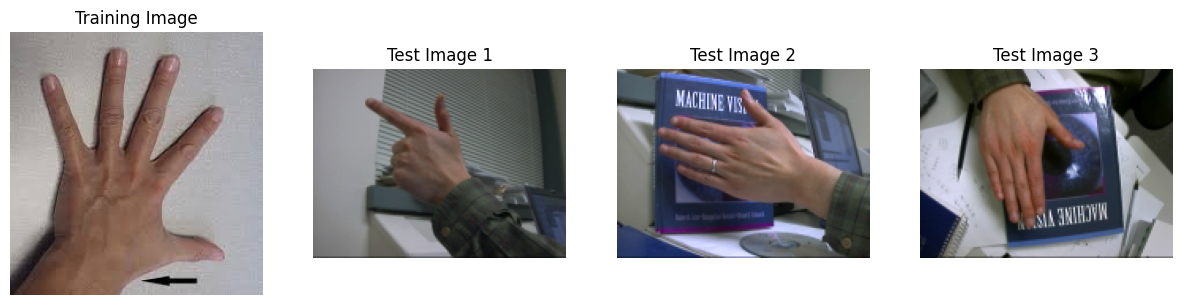

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Loading training image
locate = 'images.jpeg'
trn_im = cv2.imread(locate)
trn_im_rgb = cv2.cvtColor(trn_im, cv2.COLOR_BGR2RGB)

# Loading images
test_im_p = ['gun1.bmp', 'pointer1.bmp', 'joy1.bmp']
test_im_b = [cv2.imread(path) for path in test_im_p]
test_im_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in test_im_b]

# Displaying images
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(trn_im_rgb)
plt.title("Training Image")
plt.axis('off')

for i, img in enumerate(test_im_rgb):
    plt.subplot(1, 4, i + 2)
    plt.imshow(img)
    plt.title(f"Test Image {i + 1}")
    plt.axis('off')
plt.show()

Select a region of interest (ROI) for skin pixels.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


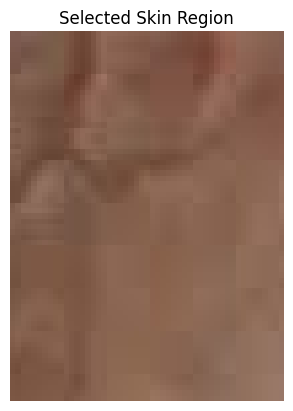

In [2]:
def collect_skin_pixels(im):
    print("Select a region of interest (ROI) for skin pixels.")
    im_disp = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #converting to RGB for visualization
    roi = cv2.selectROI("Select Skin Region", cv2.cvtColor(im_disp, cv2.COLOR_RGB2BGR))
    cv2.destroyAllWindows()
    x, y, w, h = roi
    return im[y:y+h, x:x+w]

skn_reg = collect_skin_pixels(trn_im)
skn_pix = skn_reg.reshape(-1, 3)

plt.imshow(cv2.cvtColor(skn_reg, cv2.COLOR_BGR2RGB))
plt.title("Selected Skin Region")
plt.axis('off')
plt.show()

In [3]:
def color_space(im, space='HSV'):
    if space == 'HSV':
        return cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    elif space == 'LAB':
        return cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    elif space == 'YCrCb':
        return cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    
# Converting to different color spaces
skn_pix_hsv = color_space(skn_reg, space='HSV').reshape(-1, 3)
skn_pix_lab = color_space(skn_reg, space='LAB').reshape(-1, 3)
skn_pix_ycrcb = color_space(skn_reg, space='YCrCb').reshape(-1, 3)

In [ ]:
from scipy.stats import gaussian_kde

def trn_hist(pix, bins=16, range_=[[0, 255], [0, 255]]):
    hist, x_edges, y_edges = np.histogram2d(
        pix[:, 0], pix[:, 1], bins=bins, range=range_
    )
    hist = hist / hist.sum()
    return hist, x_edges, y_edges

# Training histograms
rgb_hist, rgb_x_edges, rgb_y_edges = trn_hist(skn_pix)
hsv_hist, hsv_x_edges, hsv_y_edges = trn_hist(skn_pix_hsv)
lab_hist, lab_x_edges, lab_y_edges = trn_hist(skn_pix_lab)
ycrcb_hist, ycrcb_x_edges, ycrcb_y_edges = trn_hist(skn_pix_ycrcb)


In [5]:
def app_hist(im, hist, x_edges, y_edges):
    height, width, _ = im.shape
    flat_im = im.reshape(-1, 3)
    segm = np.zeros((flat_im.shape[0],), dtype=np.uint8)
    for i, pixel in enumerate(flat_im):
        x_bin = np.digitize(pixel[0], x_edges) - 1
        y_bin = np.digitize(pixel[1], y_edges) - 1
        if 0 <= x_bin < hist.shape[0] and 0 <= y_bin < hist.shape[1]:
            segm[i] = hist[x_bin, y_bin] > 0
    return segm.reshape(height, width)


# Apply the trained histograms to test images
segmented_images_rgb = [app_hist(img, rgb_hist, rgb_x_edges, rgb_y_edges) for img in test_im_b]
segmented_images_hsv = [app_hist(color_space(img, 'HSV'), hsv_hist, hsv_x_edges, hsv_y_edges) for img in test_im_b]
segmented_images_lab = [app_hist(color_space(img, 'LAB'), lab_hist, lab_x_edges, lab_y_edges) for img in test_im_b]
segmented_images_ycrcb = [app_hist(color_space(img, 'YCrCb'), ycrcb_hist, ycrcb_x_edges, ycrcb_y_edges) for img in test_im_b]

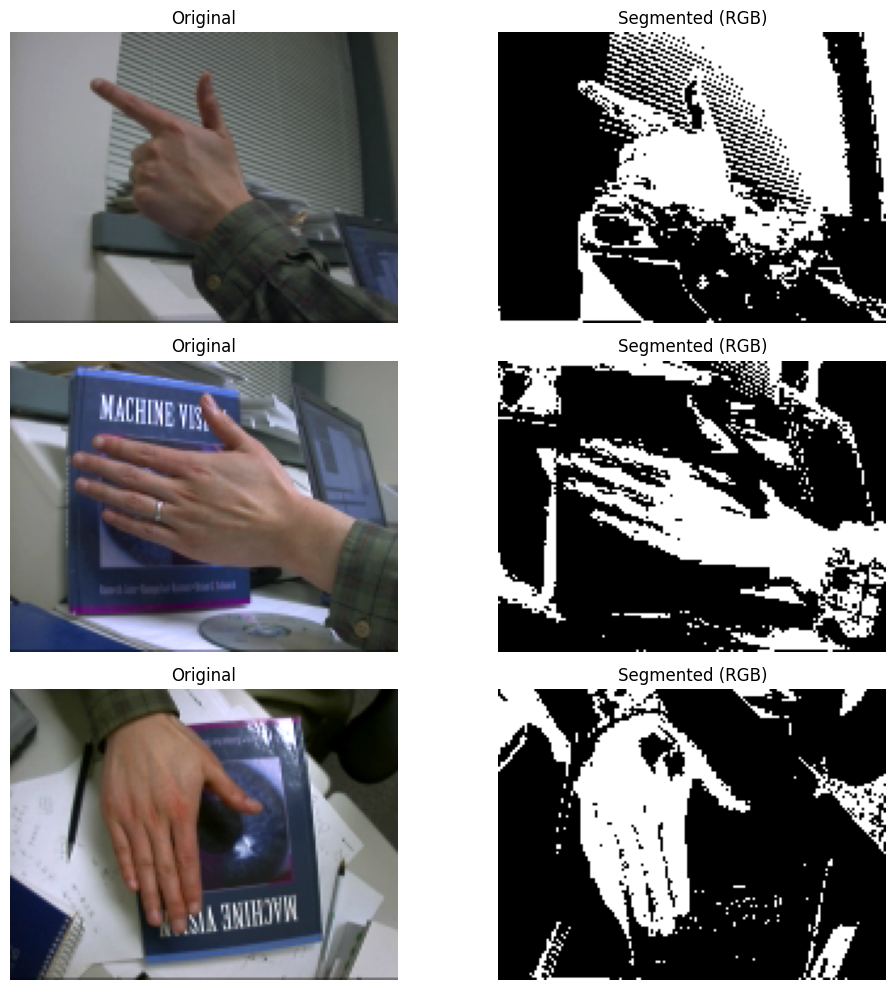

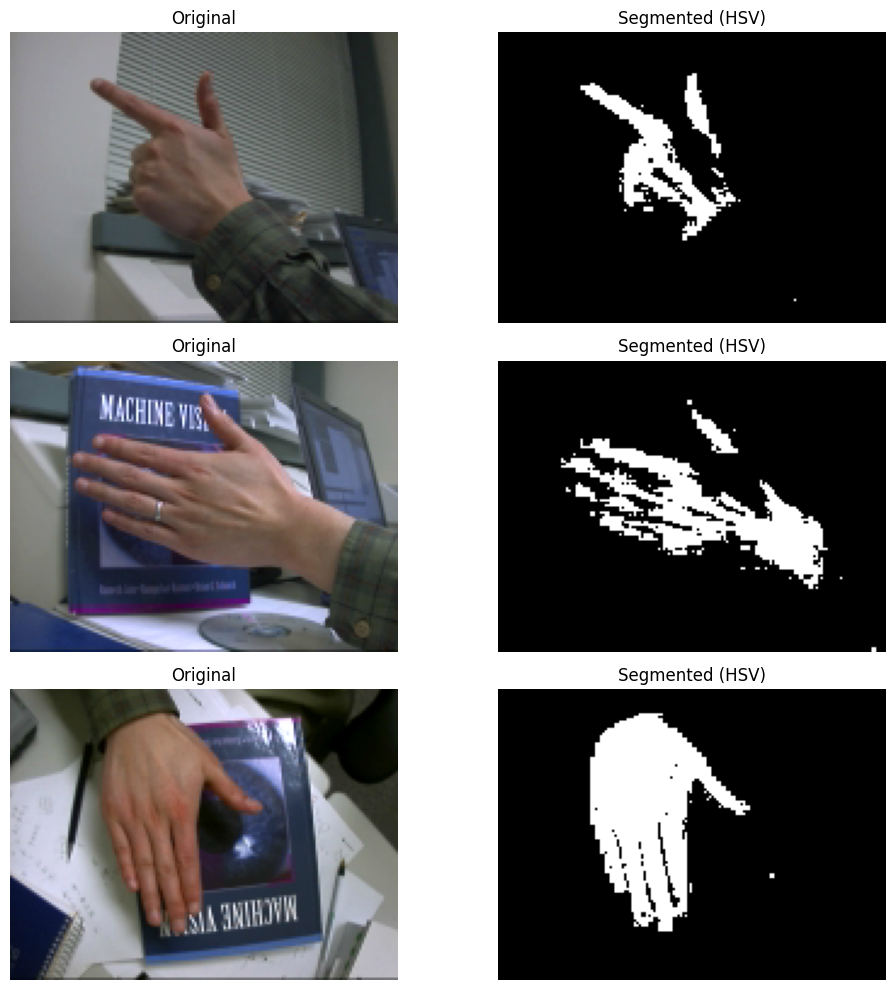

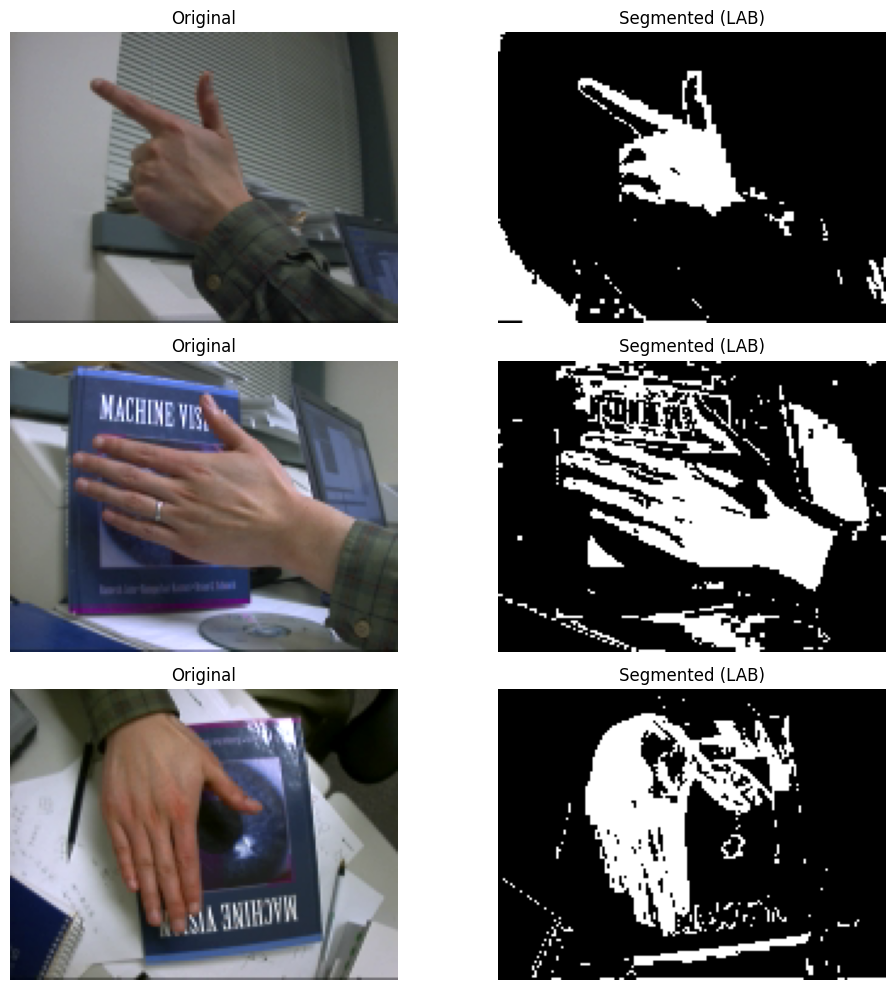

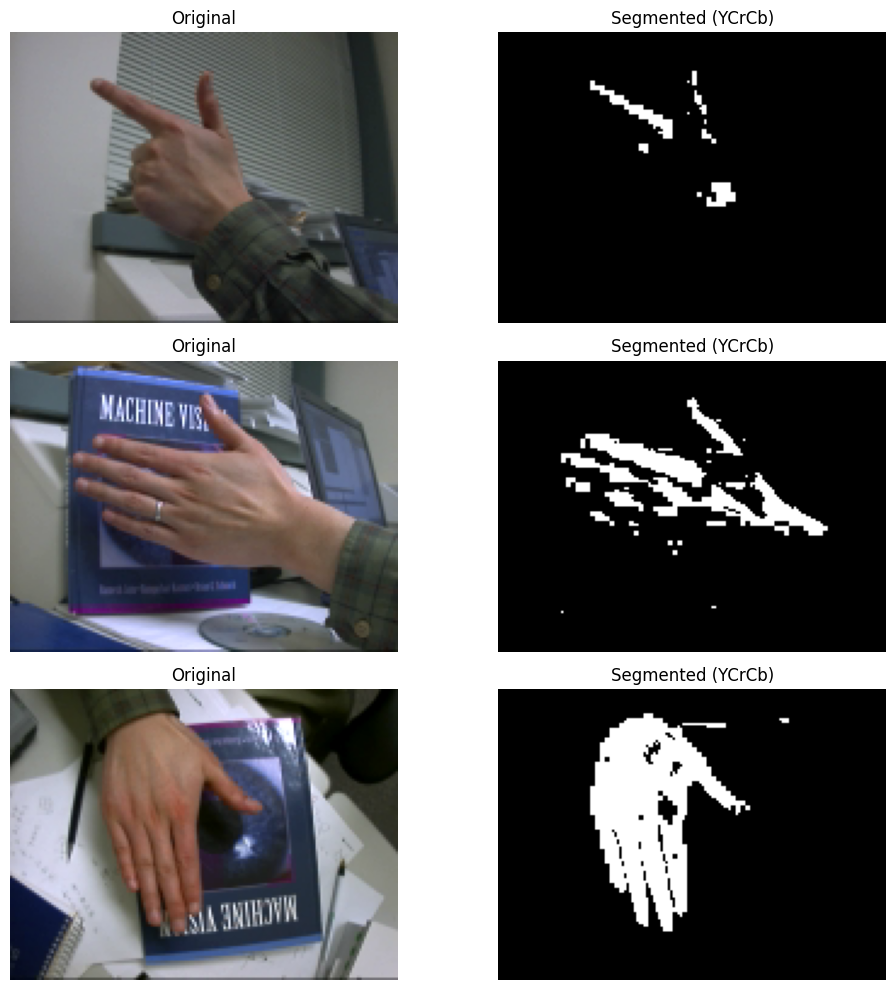

In [6]:
def visualize_results(original_images, segmented_images, title):
    plt.figure(figsize=(15, 10))
    for i, (original, segmented) in enumerate(zip(original_images, segmented_images)):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(segmented, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizing for each color space
visualize_results(test_im_b, segmented_images_rgb, "Segmented (RGB)")
visualize_results(test_im_b, segmented_images_hsv, "Segmented (HSV)")
visualize_results(test_im_b, segmented_images_lab, "Segmented (LAB)")
visualize_results(test_im_b, segmented_images_ycrcb, "Segmented (YCrCb)")


# Guassian Implementation

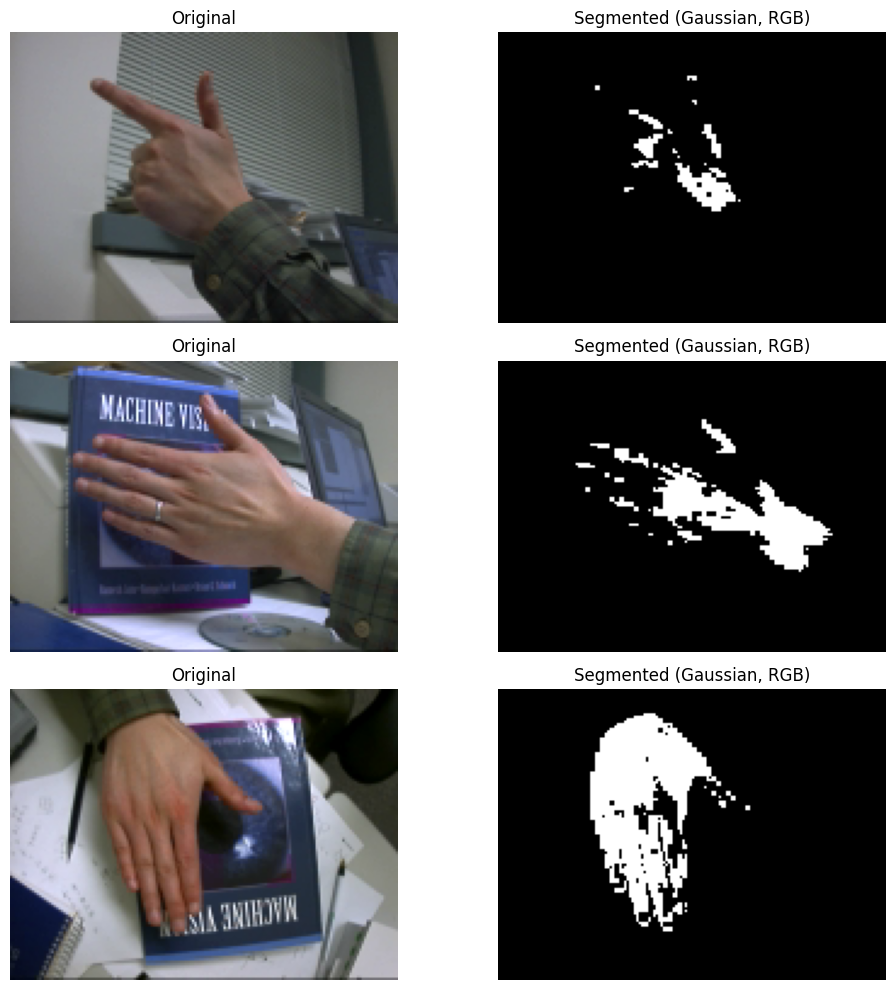

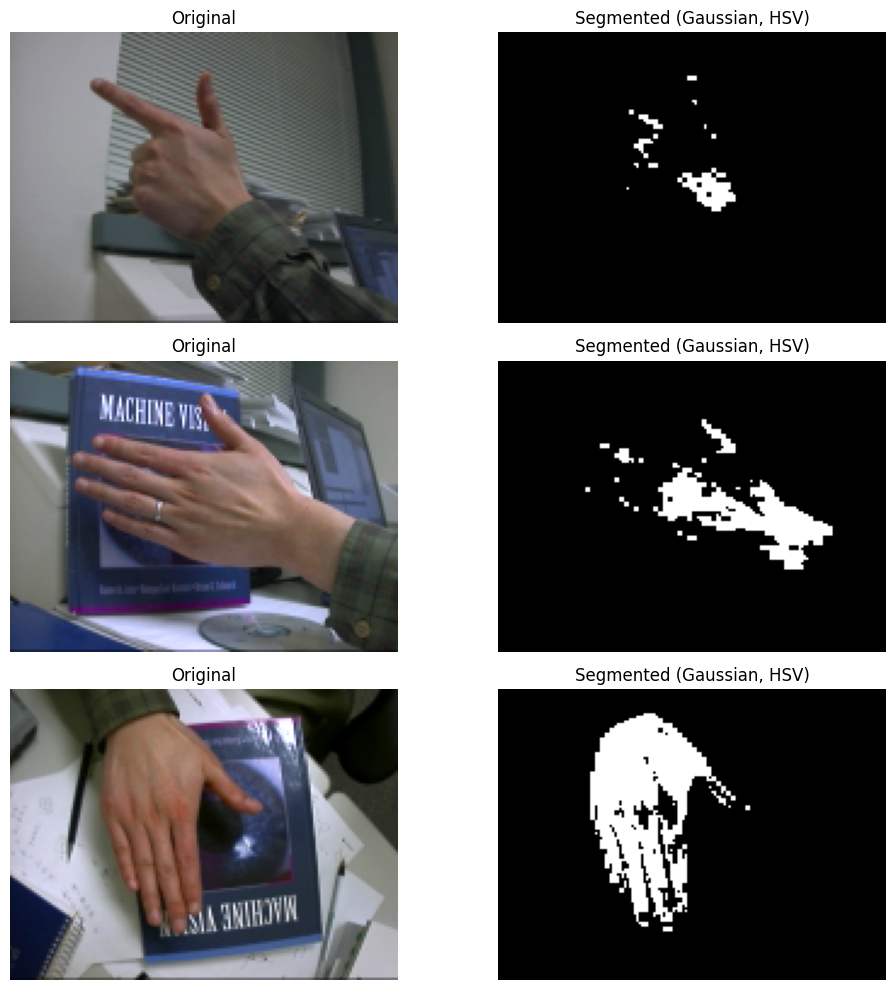

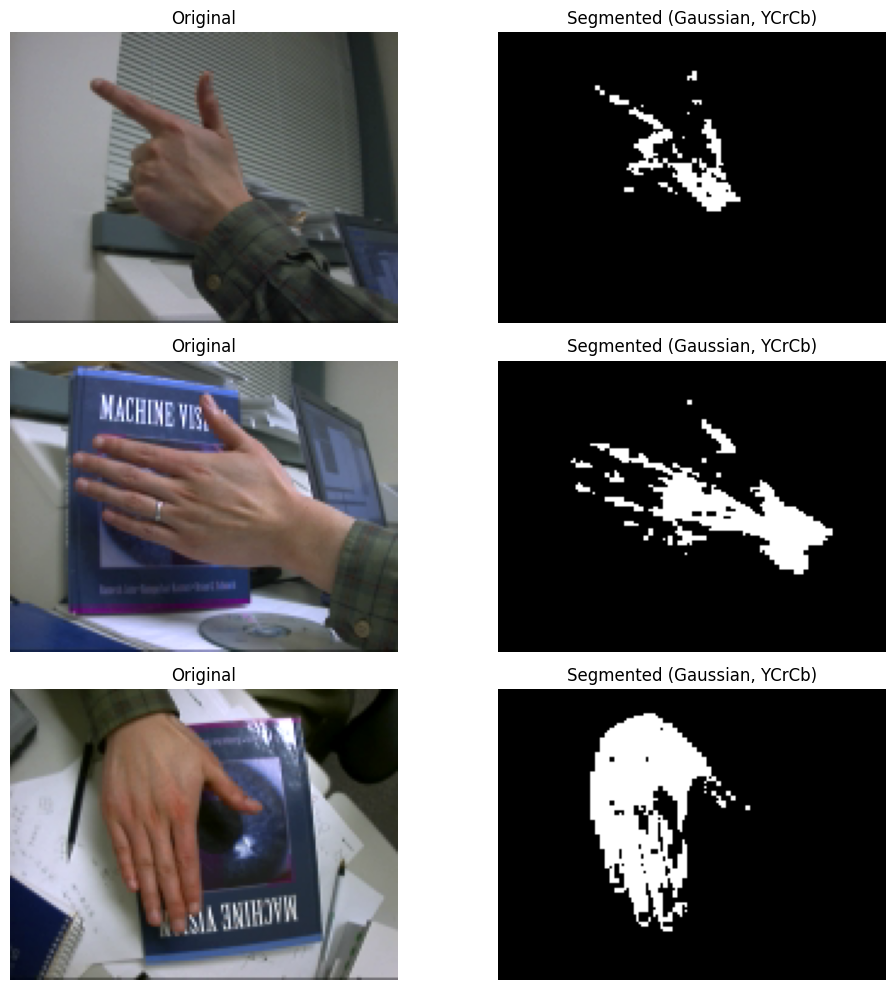

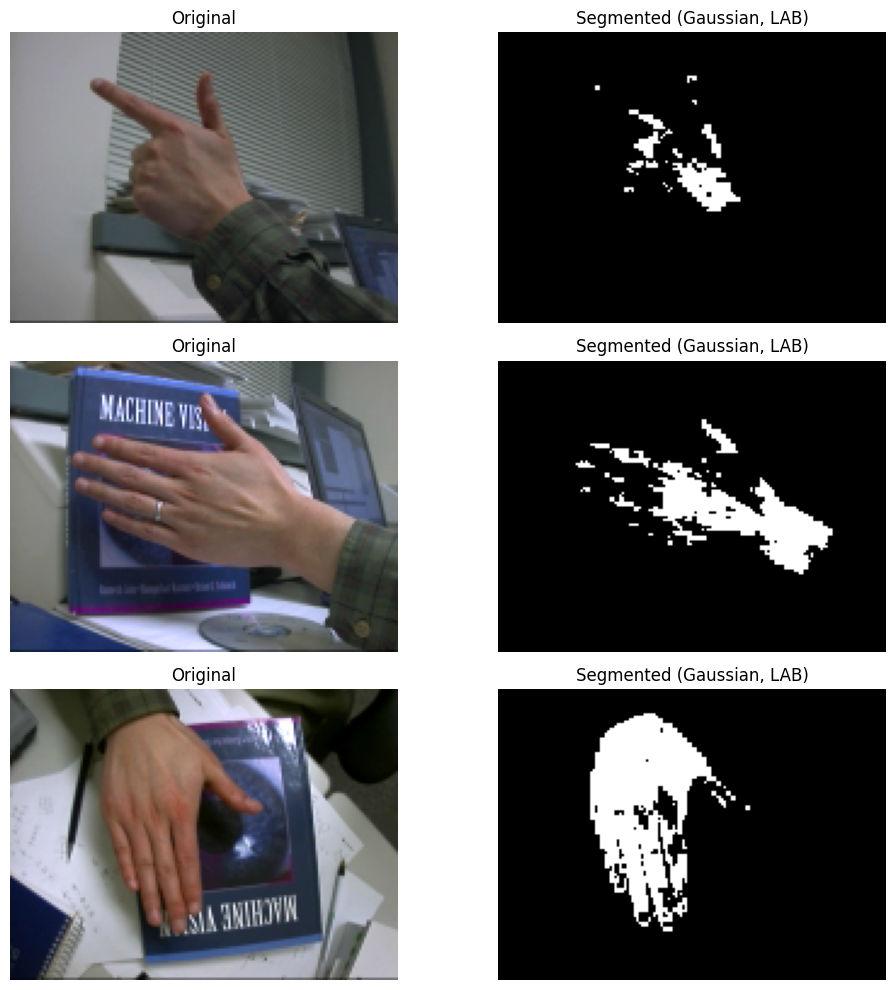

In [7]:
from scipy.stats import multivariate_normal

def norm_pix(pixels):
    return pixels / 255.0

skn_pix_rgb_norm = norm_pix(skn_pix)
skn_pix_hsv_norm = norm_pix(skn_pix_hsv)
skn_pix_ycrcb_norm = norm_pix(skn_pix_ycrcb)
skn_pix_lab_norm = norm_pix(skn_pix_lab)

def trn_gaussian(pix):
    mean = np.mean(pix, axis=0)
    cov = np.cov(pix, rowvar=False)
    return multivariate_normal(mean=mean, cov=cov)

gauss_rgb = trn_gaussian(skn_pix_rgb_norm)
gauss_hsv = trn_gaussian(skn_pix_hsv_norm)
gauss_ycrcb = trn_gaussian(skn_pix_ycrcb_norm)
gauss_lab = trn_gaussian(skn_pix_lab_norm)

def app_gauss(im, gauss, co_space, threshold=0.01):
    if co_space == 'HSV':
        img_converted = cv2.cvtColor(im, cv2.COLOR_BGR2HSV) / 255.0
    elif co_space == 'YCrCb':
        img_converted = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb) / 255.0
    elif co_space == 'LAB':
        img_converted = cv2.cvtColor(im, cv2.COLOR_BGR2LAB) / 255.0
    else:
        img_converted = im / 255.0
    
    flat_im = img_converted.reshape(-1, img_converted.shape[-1])
    probs = gauss.pdf(flat_im)
    segm = (probs > threshold).astype(np.uint8)
    return segm.reshape(im.shape[:2])

segm_im_gauss_rgb = [app_gauss(img, gauss_rgb, 'RGB') for img in test_im_b]
segm_im_gauss_hsv = [app_gauss(img, gauss_hsv, 'HSV') for img in test_im_b]
segm_im_gauss_ycrcb = [app_gauss(img, gauss_ycrcb, 'YCrCb') for img in test_im_b]
segm_im_gauss_lab = [app_gauss(img, gauss_lab, 'LAB') for img in test_im_b]

visualize_results(test_im_b, segm_im_gauss_rgb, "Segmented (Gaussian, RGB)")
visualize_results(test_im_b, segm_im_gauss_hsv, "Segmented (Gaussian, HSV)")
visualize_results(test_im_b, segm_im_gauss_ycrcb, "Segmented (Gaussian, YCrCb)")
visualize_results(test_im_b, segm_im_gauss_lab, "Segmented (Gaussian, LAB)")